## Functional prediction using q2-picrust

### Load Modules

Install biom

In [31]:
! conda install -c bioconda biom-format

Retrieving notices: ...working... done
Channels:
 - bioconda
 - defaults
 - conda-forge
 - https://packages.qiime2.org/qiime2/2024.5/amplicon/released
 - https://packages.qiime2.org/qiime2/2024.5/metagenome/staged
 - picrust
Platform: linux-64
Solving environment: \ warning  libmamba Added empty dependency for problem type SOLVER_RULE_UPDATE
failed

LibMambaUnsatisfiableError: Encountered problems while solving:
  - package spades-3.15.2-h95f258a_1 requires sysroot_linux-64 2.17.*, but none of the providers can be installed
  - package cutadapt-4.9-py39hff71179_1 requires python_abi 3.9.* *_cp39, but none of the providers can be installed
  - package sepp-4.4.0-py39_0 requires python_abi 3.9.* *_cp39, but none of the providers can be installed

Could not solve for environment specs
The following packages are incompatible
├─ bowtie2 2.5.4**  is requested and can be installed;
├─ cutadapt is installable with the potential options
│  ├─ cutadapt [3.3|3.4|...|4.9] would require
│  │  └─ py

In [1]:
import os
import sys
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from skbio import OrdinationResults
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import scatterplot
%matplotlib inline

# Define the data directory
data_dir = './data'

#### 1. Download FUNGuild  
Clone the repository

In [2]:
! git clone https://github.com/UMNFuN/FUNGuild.git

fatal: destination path 'FUNGuild' already exists and is not an empty directory.


#### 2. Export taxonomy as a tsv file so we can use it for FUNGuild  
Clone the repository

In [3]:
! qiime tools export \
    --input-path ./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qza \
    --output-path ./data/taxonomy_classification/exported-taxonomy

^C

Aborted!


#### 3. Format input data
Fix the column name for the taxonomy.tsv because FUNGuild can only use the column name "taxonomy" and not "Taxon".

In [4]:
# Load the file
df = pd.read_csv('./data/taxonomy_classification/exported-taxonomy/taxonomy.tsv', sep='\t')

# Rename the column
df.rename(columns={'Taxon': 'taxonomy'}, inplace=True)

# Save the updated file
df.to_csv('./data/taxonomy_classification/exported-taxonomy/taxonomy_fixed.tsv', sep='\t', index=False)

#### 4. Run FUNGuild

Below is the code for the FUNGuild.  
otu: path to the taxonomy file  
db: specifying that fungal database is the one that we will use  
m: output a table with only matched (function-assigned) OTUs  
u: output a table with only unmatched OTUs

In [14]:
! python ./FUNGuild/Guilds_v1.1.py \
    -otu ./data/taxonomy_classification/exported-taxonomy/taxonomy_fixed.tsv \
    -db fungi \
    -m \
    -u

FunGuild v1.1 Beta
Connecting with FUNGuild database ...

Reading in the OTU table: './data/taxonomy_classification/exported-taxonomy/taxonomy_fixed.tsv'

Searching the FUNGuild database...
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%

Found 1091 matching taxonomy records in the database.
Dereplicating and sorting the result...
FunGuild tried to assign function to 1021 OTUs in './data/taxonomy_classification/exported-taxonomy/taxonomy_fixed.tsv'.
FUNGuild made assignments on 693 OTUs.
Result saved to './data/taxonomy_classification/exported-taxonomy/taxonomy_fixed.guilds.txt'

Additional output:
FUNGuild made assignments on 693 OTUs, these have been saved to ./data/taxonomy_classification/exported-taxonomy/taxonomy_fixed.guilds_matched.txt.
328 OTUs were unassigned, these are saved to ./data/taxonomy_classification/exported-taxonomy/taxonomy_fixed.guilds_unmatched.txt.

Total calculating time: 5.96 seconds.


#### The output has several columns:  
Taxon: Original taxonomic assignment.  
Trophic Mode: Ecological role (e.g., saprotroph, pathogen).  
Guild: Specific guild (e.g., plant pathogen, ectomycorrhizal).  
Confidence: Confidence level of the assignment.

#### 5. Look at the created data

In [5]:
df_matched_guilds = pd.read_csv('./data/taxonomy_classification/exported-taxonomy/taxonomy_fixed.guilds_matched.txt', sep='\t')
print(df_matched_guilds['Guild'].value_counts())

Guild
Undefined Saprotroph                                                                        230
|Undefined Saprotroph|                                                                       95
Animal Pathogen-Plant Pathogen-|Undefined Saprotroph|                                        60
Animal Pathogen-Endophyte-Endosymbiont-Epiphyte-|Undefined Saprotroph|                       56
Animal Parasite-Animal Pathogen-Animal Symbiotroph-Plant Pathogen-|Undefined Saprotroph|     42
                                                                                           ... 
Ectomycorrhizal-|Undefined Saprotroph|-Wood Saprotroph                                        1
Endophyte-Nematophagous-Plant Pathogen-|Wood Saprotroph|                                      1
Epiphyte-|Undefined Saprotroph|                                                               1
|Plant Saprotroph|-Undefined Saprotroph-Wood Saprotroph                                       1
|Dung Saprotroph|-Undefined Saprot

In [6]:
#filter by confidence level 
df_matched_guilds[df_matched_guilds['Confidence'] > 0.7]

,Feature ID,taxonomy,Confidence,Taxon,Taxon Level,Trophic Mode,Guild,Growth Morphology,Trait,Confidence Ranking,Notes,Citation/Source
0,004c991a685b11054001b8c7d0a68543,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.954798,Saccharomycetales,7,Saprotroph,Undefined Saprotroph,Yeast,NaN,Possible,NaN,"b'Sterkenburg E, et al. 2015. New Phytologist ..."
1,0113430ae816d67262d3c86660ecd51e,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.802044,Saccharomycetales,7,Saprotroph,Undefined Saprotroph,Yeast,NaN,Possible,NaN,"b'Sterkenburg E, et al. 2015. New Phytologist ..."
2,01202eb8b50e4b6ac670afc696cf804c,k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eu...,0.999728,Aspergillus,13,Pathotroph-Saprotroph-Symbiotroph,Animal Pathogen-Endophyte-Plant Saprotroph-|Un...,Microfungus,NaN,Probable,As foliar_endophyte (Põlme et al. 2020); Decay...,"b'Seehann G, et al. 1975. List of Fungi in Sof..."
3,014a604d3dadcb95ddc73b1d6c642b45,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.900741,Saccharomycetales,7,Saprotroph,Undefined Saprotroph,Yeast,NaN,Possible,NaN,"b'Sterkenburg E, et al. 2015. New Phytologist ..."
4,01ab17a41e837c842a5a232385a99169,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.956831,Candida,13,Pathotroph-Saprotroph-Symbiotroph,Animal Pathogen-Endophyte-Endosymbiont-Epiphyt...,Dimorphic Yeast-Yeast,NaN,Probable,As nectar-tap_saprotroph (Põlme et al. 2020); ...,"b'Manolakaki D, et al. 2010. Virulence. 1: 367..."
...,...,...,...,...,...,...,...,...,...,...,...,...
688,ff026a993319972d8bec281f38aeacc3,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.999925,Candida,13,Pathotroph-Saprotroph-Symbiotroph,Animal Pathogen-Endophyte-Endosymbiont-Epiphyt...,Dimorphic Yeast-Yeast,NaN,Probable,As nectar-tap_saprotroph (Põlme et al. 2020); ...,"b'Manolakaki D, et al. 2010. Virulence. 1: 367..."
689,ff8c880f0650931cb829568034d00a78,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.992525,Meyerozyma,13,Saprotroph-Symbiotroph,Endophyte-|Epiphyte|-Undefined Saprotroph,Yeast,NaN,Probable,As foliar_endophyte (Põlme et al. 2020); As ne...,"b'P\xc3\xb5lme S, et al. 2020. Fungal Diversit..."
690,ffafb7e58eb5ffd894cf6b5a4610dc89,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.720555,Geotrichum,13,Pathotroph-Saprotroph,Animal Pathogen-Plant Pathogen-|Undefined Sapr...,Microfungus,NaN,Probable,As nectar-tap_saprotroph (Põlme et al. 2020); ...,"b'Thornton CR, et al. 2010. International Jour..."
691,ffd273afcb47f6101f2f9c7a03915a3c,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.964271,Candida,13,Pathotroph-Saprotroph-Symbiotroph,Animal Pathogen-Endophyte-Endosymbiont-Epiphyt...,Dimorphic Yeast-Yeast,NaN,Probable,As nectar-tap_saprotroph (Põlme et al. 2020); ...,"b'Manolakaki D, et al. 2010. Virulence. 1: 367..."


#### 6. Prepare the data for beta diversity analysis  
To be able to use this data for qqime 2, we need to fix the format:  
Rows represent samples (based on the Feature ID).  
Columns represent guilds.  
Values represent the abundance of each guild in a sample.

In [10]:
# Pivot the table to create a feature table
feature_table = df_matched_guilds.pivot_table(index='Feature ID', columns='Guild', values='Confidence', aggfunc='sum').fillna(0)

# Save the feature table
feature_table.to_csv('./FUNGuild/beta_diversity_feature_table.tsv', sep='\t')

#### 7. Import data to QQIME 2
QIIME 2 requires feature tables to have a specific format and metadata structure to perform downstream analyses, and "OTU table" is one of the accepted types for representing microbial abundance data.

In [11]:
#use biom to convert the table into soemthing QQIME2 can work with
! biom convert \
  -i ./FUNGuild/beta_diversity_feature_table.tsv \
  -o ./FUNGuild/beta_diversity_feature_table.biom \
  --table-type="OTU table" \
  --to-hdf5

In [12]:
! qiime tools import \
  --type 'FeatureTable[Frequency]' \
  --input-path ./FUNGuild/beta_diversity_feature_table.biom \
  --output-path ./FUNGuild/beta_diversity_feature_table.qza

Imported ./FUNGuild/beta_diversity_feature_table.biom as BIOMV210DirFmt to ./FUNGuild/beta_diversity_feature_table.qza


#### 8. Perform beta diversity analysis
##### 8.1. Generate distance matrix

In [13]:
! qiime diversity beta \
    --i-table ./FUNGuild/beta_diversity_feature_table.qza \
    --p-metric braycurtis \
    --o-distance-matrix ./FUNGuild/braycurtis_distance_matrix_FUNGuild.qza

Saved DistanceMatrix to: ./FUNGuild/braycurtis_distance_matrix_FUNGuild.qza


##### 8.2. Perform PCoA

In [15]:
! qiime diversity pcoa \
    --i-distance-matrix ./FUNGuild/braycurtis_distance_matrix_FUNGuild.qza \
    --o-pcoa ./FUNGuild/braycurtis_pcoa_FUNGuild.qza

Saved PCoAResults to: ./FUNGuild/braycurtis_pcoa_FUNGuild.qza


##### 8.3. Visualize Beta Diversity

In [42]:
! qiime tools export \
    --input-path ./data/feature_tables_dada/filtered-feature-table.qza \
    --output-path ./data/feature_tables_data/exported-feature-table
#it is exported as a .biom so we need to convert it to tsv so we can work on it

Exported ./data/filtered-feature-table.qza as BIOMV210DirFmt to directory ./data/exported-feature-table


In [18]:
! biom convert \
  -i ./data/feature_tables_dada/exported-feature-table/feature-table.biom \
  -o ./data/feature_tables_dada/exported-feature-table/feature-table.tsv \
  --to-tsv

In [19]:
#look at the table that we made so that we can see the IDs and the features 
! head ./data/feature_tables_dada/exported-feature-table/feature-table.tsv

# Constructed from biom file
#OTU ID	ERR5327198	ERR5327199	ERR5327266	ERR5327282	ERR5327284	ERR5327285	ERR5327287	ERR5327288	ERR5327289	ERR5327300	ERR5327303	ERR5327305	ERR5327308	ERR5327311	ERR5327313	ERR5327314	ERR5327316	ERR5327317	ERR5327318	ERR5327322	ERR5327323	ERR5327325	ERR5327326	ERR5327327	ERR5327329	ERR5327332	ERR5327335	ERR5327338	ERR5327340	ERR5327343	ERR5327344	ERR5327346	ERR5327348	ERR5327349	ERR5327351	ERR5327352	ERR5327353	ERR5327354	ERR5327355	ERR5327356	ERR5327360	ERR5327362	ERR5327363	ERR5327364	ERR5327367	ERR5327379	ERR5327387	ERR5327388	ERR5327394	ERR5327395	ERR5327396	ERR5327401	ERR5327402	ERR5327404	ERR5327405	ERR5327406	ERR5327407	ERR5327408	ERR5327409	ERR5327410	ERR5327412	ERR5327414	ERR5327415	ERR5327416	ERR5327418	ERR5327419	ERR5327421	ERR5327426	ERR5327427	ERR5327428	ERR5327431	ERR5327432	ERR5327433	ERR5327434	ERR5327435	ERR5327439	ERR5327442	ERR5327443	ERR5327444	ERR5327445	ERR5327447	ERR5327450	ERR5327452	ERR5327456	ERR5327464	ERR5327465	ERR5327470	ERR532

##### 8.4. Prepare the Table for QIIME 2  
convert .biom format back to BIOM format and import it into QIIME 2

In [20]:
! biom convert \
  -i ./data/feature_tables_dada/exported-feature-table/feature-table.tsv \
  -o ./data/feature_tables_dada/exported-feature-table/feature-table.biom \
  --table-type="OTU table" \
  --to-hdf5

Import it into QIIME 2

In [21]:
! qiime tools import \
  --type 'FeatureTable[Frequency]' \
  --input-path ./data/feature_tables_dada/exported-feature-table/feature-table.biom \
  --output-path ./data/feature_tables_dada/feature-table.qza

Imported ./data/feature_tables_dada/exported-feature-table/feature-table.biom as BIOMV210DirFmt to ./data/feature_tables_dada/feature-table.qza


##### 8.5. Compute the distance matrix

In [22]:
! qiime diversity beta \
    --i-table ./data/feature_tables_dada/feature-table.qza \
    --p-metric braycurtis \
    --o-distance-matrix ./FUNGuild/braycurtis_distance_matrix_FUNGuild.qza

Saved DistanceMatrix to: ./FUNGuild/braycurtis_distance_matrix_FUNGuild.qza


Generate PCoA plots:

In [23]:
! qiime diversity pcoa \
    --i-distance-matrix ./FUNGuild/braycurtis_distance_matrix_FUNGuild.qza \
    --o-pcoa ./FUNGuild/braycurtis_pcoa_FUNGuild.qza


Saved PCoAResults to: ./FUNGuild/braycurtis_pcoa_FUNGuild.qza


Visualize with Emperor:

In [26]:
! qiime emperor plot \
    --i-pcoa ./FUNGuild/braycurtis_pcoa_FUNGuild.qza \
    --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
    --o-visualization ./FUNGuild/braycurtis_emperor_FUNGuild.qzv

Saved Visualization to: ./FUNGuild/braycurtis_emperor_FUNGuild.qzv


In [28]:
Visualization.load('./FUNGuild/braycurtis_emperor_FUNGuild.qzv')

<visualization: Visualization uuid: d9367f6d-d6c2-4eb7-98b3-0fccfba67e54>

#### 9.Visualizing PCoA data with pandas and seaborn
The following code block will allow us to view the ordination results as a pandas DataFrame:

In [31]:
# Load my pcoa data
data_dir = './FUNGuild'
pcs = q2.Artifact.load(os.path.join(data_dir, 'braycurtis_pcoa_FUNGuild.qza'))

# View as an OrdinationResults object
pcs = pcs.view(OrdinationResults)

# Take the first 3 columns (PCoA axes)
pcs_data = pcs.samples.iloc[:, :3]

# Rename the columns for clarity
pcs_data.columns = ['Axis 1', 'Axis 2', 'Axis 3']

              Axis 1    Axis 2    Axis 3
ERR5327198 -0.171080 -0.054150  0.027704
ERR5327199 -0.183502 -0.059634  0.034160
ERR5327266  0.527028  0.018344 -0.009009
ERR5327282 -0.178416 -0.054769  0.025097
ERR5327284 -0.184337 -0.062887  0.044572


In [29]:
meta_data = pd.read_csv('./data/metadata/fungut_metadata_processed.tsv', sep='\t')

In [46]:
pcs_data_gluten = pd.merge(pcs_data, meta_data[['ID', 'gluten_symptoms']], left_index=True, right_on='ID')

In [43]:
pcs_data_IBD = pd.merge(pcs_data, meta_data[['ID', 'ibd_symptoms']], left_index=True, right_on='ID')

Now we can plot these data. We will use the Python visualization library seaborn to quickly make a nice tidy scatterplot.

<Axes: xlabel='Axis 1', ylabel='Axis 2'>

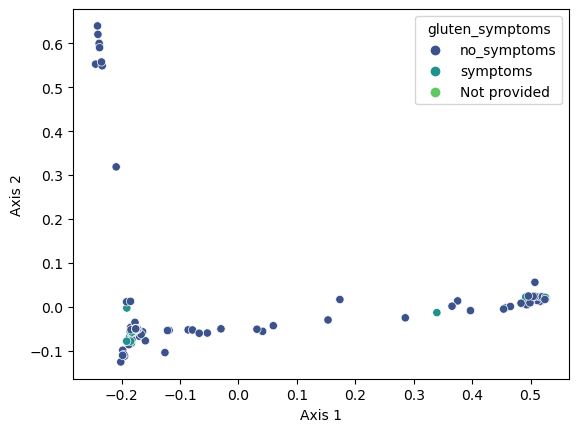

In [48]:
scatterplot(data=pcs_data_gluten,
            x='Axis 1',
            y='Axis 2',
            hue='gluten_symptoms',
            palette='viridis')

<Axes: xlabel='Axis 1', ylabel='Axis 2'>

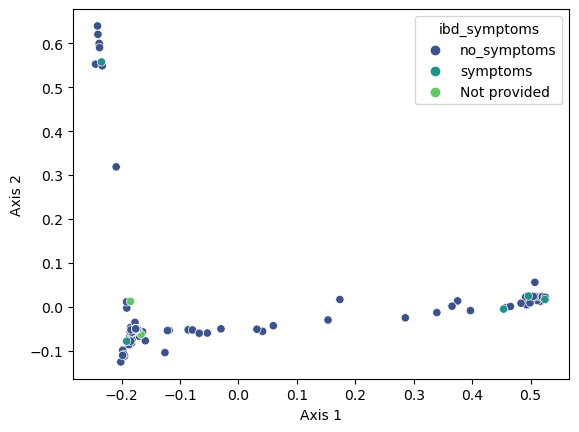

In [44]:
scatterplot(data=pcs_data_IBD,
            x='Axis 1',
            y='Axis 2',
            hue='ibd_symptoms',
            palette='viridis')

#### 10. Statistical testing using PERMANOVA

Gluten

In [3]:
! qiime diversity beta-group-significance \
  --i-distance-matrix ./FUNGuild/braycurtis_distance_matrix_FUNGuild.qza \
  --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
  --m-metadata-column gluten_symptoms \
  --o-visualization ./FUNGuild/beta_group_significance_gluten.qzv

Usage: qiime diversity beta-group-significance [OPTIONS]

  Determine whether groups of samples are significantly different from one
  another using a permutation-based statistical test.

Inputs:
  --i-distance-matrix ARTIFACT
    DistanceMatrix     Matrix of distances between pairs of samples.
                                                                    [required]
Parameters:
  --m-metadata-file METADATA
  --m-metadata-column COLUMN  MetadataColumn[Categorical]
                       Categorical sample metadata column.          [required]
  --p-method TEXT Choices('permanova', 'anosim', 'permdisp')
                       The group significance test to be applied.
                                                        [default: 'permanova']
  --p-pairwise / --p-no-pairwise
                       Perform pairwise tests between all pairs of groups in
                       addition to the test across all groups. This can be
                       very slow if there are a lot of g

In [2]:
Visualization.load('./FUNGuild/beta_group_significance_gluten.qzv')

ValueError: FUNGuild/beta_group_significance_gluten.qzv does not exist.

There does not seem to be a significant difference in the people with gluten symptoms and those without. 

In [53]:
! qiime diversity beta-group-significance \
  --i-distance-matrix ./FUNGuild/braycurtis_distance_matrix_FUNGuild.qza \
  --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
  --m-metadata-column ibd_symptoms \
  --o-visualization ./FUNGuild/beta_group_significance_ibd.qzv

Saved Visualization to: ./FUNGuild/beta_group_significance_ibd.qzv


In [ ]:
Visualization.load('./FUNGuild/beta_group_significance_ibd.qzv')

There does not seem to be a significant difference in the people with ibd symptoms and those without. 

In [54]:
! qiime diversity beta-group-significance \
  --i-distance-matrix ./FUNGuild/braycurtis_distance_matrix_FUNGuild.qza \
  --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
  --m-metadata-column is_urban \
  --o-visualization ./FUNGuild/beta_group_significance_urban.qzv

Saved Visualization to: ./FUNGuild/beta_group_significance_urban.qzv


In [60]:
Visualization.load('./FUNGuild/beta_group_significance_urban.qzv')

<visualization: Visualization uuid: 42e81afd-eb85-4261-a162-c8d431aba6f9>

There does not seem to be a significant difference in the people living urban and rural places. 

In [62]:
! qiime diversity beta-group-significance \
  --i-distance-matrix ./FUNGuild/braycurtis_distance_matrix_FUNGuild.qza \
  --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
  --m-metadata-column age_group \
  --o-visualization ./FUNGuild/beta_group_significance_age.qzv

Saved Visualization to: ./FUNGuild/beta_group_significance_age.qzv


In [64]:
Visualization.load('./FUNGuild/beta_group_significance_age.qzv')

<visualization: Visualization uuid: 0b415522-bcaf-447f-afdb-1e281ccc8401>

There does not seem to be a significant difference in the ages of the people. 

In [55]:
! qiime diversity beta-group-significance \
  --i-distance-matrix ./FUNGuild/braycurtis_distance_matrix_FUNGuild.qza \
  --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
  --m-metadata-column bmi_category \
  --o-visualization ./FUNGuild/beta_group_significance_bmi.qzv

Saved Visualization to: ./FUNGuild/beta_group_significance_bmi.qzv


In [63]:
Visualization.load('./FUNGuild/beta_group_significance_bmi.qzv')

<visualization: Visualization uuid: c3124583-b5c6-4839-8861-7fb3282a7808>

There does not seem to be a significant difference in the bmis. 

In [56]:
! qiime diversity beta-group-significance \
  --i-distance-matrix ./FUNGuild/braycurtis_distance_matrix_FUNGuild.qza \
  --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
  --m-metadata-column country_sample \
  --o-visualization ./FUNGuild/beta_group_significance_country.qzv

Saved Visualization to: ./FUNGuild/beta_group_significance_country.qzv


In [65]:
Visualization.load('./FUNGuild/beta_group_significance_country.qzv')

<visualization: Visualization uuid: b32caa64-0e3a-4e64-a46a-c8f63a01a2fb>

There does not seem to be a significant difference in the different countries. 

In [58]:
! qiime diversity beta-group-significance \
  --i-distance-matrix ./FUNGuild/braycurtis_distance_matrix_FUNGuild.qza \
  --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
  --m-metadata-column diet_type_sample \
  --o-visualization ./FUNGuild/beta_group_significance_diet.qzv

Saved Visualization to: ./FUNGuild/beta_group_significance_diet.qzv


In [66]:
Visualization.load('./FUNGuild/beta_group_significance_diet.qzv')

<visualization: Visualization uuid: a1badfa8-00c6-4806-839e-0af7dce24c8d>

There does not seem to be a significant difference in the diet types. 